# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
Version = "6.5.0-Small-v1"                      # Used for tflite Filename
Training_Percentage = 0.0              # 0.0 = Use all Images for Training
Epoch_Anz = 100

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [2]:
Input_dir='ziffer_sortiert_resize'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '/*.jpg')
    if aktsubdir == "NaN":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        x_data.append(test_image)
        y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(720, 32, 20, 3)
(720, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dense(11, activation = "softmax"))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 20, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 2, 64)          0

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [4]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.3
Rotation_Angle = 10
ZoomRange = 0.4

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, epochs = Epoch_Anz)



Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
180/180 [==============================] - 1s 7ms/step - loss: 1.7772 - accuracy: 0.5292
Epoch 2/100
180/180 [==============================] - 1s 8ms/step - loss: 1.1623 - accuracy: 0.6444
Epoch 3/100
180/180 [==============================] - 1s 8ms/step - loss: 0.8140 - accuracy: 0.7556
Epoch 4/100
180/180 [==============================] - 1s 7ms/step - loss: 0.6319 - accuracy: 0.8000
Epoch 5/100
180/180 [==============================] - 1s 8ms/step - loss: 0.5510 - accuracy: 0.8167
Epoch 6/100
180/180 [==============================] - 2s 8ms/step - loss: 0.4652 - accuracy: 0.8569
Epoch 7/100
180/180 [==============================] - 1s 8ms/step - loss: 0.4161 - accuracy: 0.8722
Epoch 8/100
180/180 [==============================] - 1s 8ms/step - loss: 0.3585 - accuracy: 0.8722
Epoch 9/100
180/180 [==============================] - 1s 8ms/step - loss: 0.3715 - accuracy: 0.8875
Epoch 10/100
18

180/180 [==============================] - 2s 8ms/step - loss: 0.0820 - accuracy: 0.9847
Epoch 79/100
180/180 [==============================] - 1s 8ms/step - loss: 0.0555 - accuracy: 0.9806
Epoch 80/100
180/180 [==============================] - 2s 8ms/step - loss: 0.0312 - accuracy: 0.9861
Epoch 81/100
180/180 [==============================] - 1s 6ms/step - loss: 0.0548 - accuracy: 0.9833
Epoch 82/100
180/180 [==============================] - 1s 6ms/step - loss: 0.0146 - accuracy: 0.9958
Epoch 83/100
180/180 [==============================] - 1s 6ms/step - loss: 0.0820 - accuracy: 0.9861
Epoch 84/100
180/180 [==============================] - 1s 7ms/step - loss: 0.0725 - accuracy: 0.9833
Epoch 85/100
180/180 [==============================] - 1s 7ms/step - loss: 0.0524 - accuracy: 0.9833
Epoch 86/100
180/180 [==============================] - 1s 6ms/step - loss: 0.0501 - accuracy: 0.9819
Epoch 87/100
180/180 [==============================] - 1s 6ms/step - loss: 0.0717 - accuracy: 

### Learing result
 
* Visualization of the training and validation results

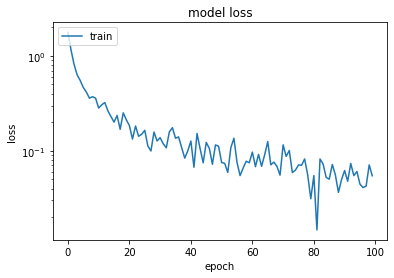

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


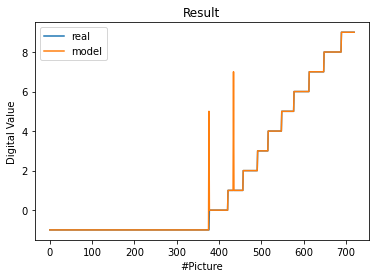

In [6]:
Input_dir='ziffer_sortiert_resize'
subdir = ["NaN", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
res = []

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    if aktsubdir == "NaN":
        zw1 = -1
    else:
        zw1 = int(aktsubdir)
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = model.predict_classes(img)
        classes = classes[0]
        if classes == 10: 
            classes = -1
        zw2 = classes
        zw3 = zw2 - zw1
        res.append(np.array([zw1, zw2, zw3]))

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [7]:
FileName = "Train_CNN_Digital-Readout_Version_" + Version
# model.save(FileName + ".h5")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

765980

In [8]:
FileName = "Train_CNN_Digital-Readout_Version_" + Version
# model.save(FileName + ".h5")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

765980

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


In [9]:
Input_dir='ziffer_sortiert_resize'
only_deviation = True

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    expected_class = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = model.predict_classes(img)
        classes = classes[0]
        if classes == 10: 
            classes = "NaN"
        if only_deviation == True:
            if str(classes) != str(expected_class):
                print(aktfile + " " + aktsubdir +  " " + str(classes))
        else:
            print(aktfile + " " + aktsubdir +  " " + str(classes))


ziffer_sortiert_resize/1\d.jpg 1 7
ziffer_sortiert_resize/NaN\Ziffer_NaN_3737.jpg NaN 5


Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.